In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from scipy import interp
import seaborn as sns
from sklearn.metrics import classification_report

from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold, GridSearchCV,train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
import xgboost as xgb

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
root='/content/drive/My Drive/data.csv'
df=pd.read_csv(root)

In [3]:
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [4]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [5]:
y = df.diagnosis                          # M or B 
x = df.iloc[:,2:32]
data = x
data_n_2 = (data - data.mean()) / (data.std())              # standardization

data visualization은 어차피 동일한 형태일테니 xgboost 부분에서만 나타내었다. 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

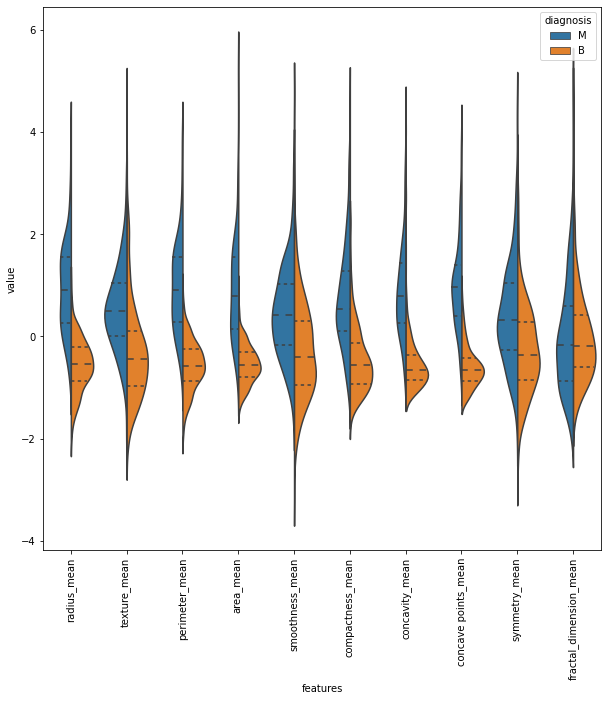

In [6]:
# mean에 관한 data visualization
data = pd.concat([y,data_n_2.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

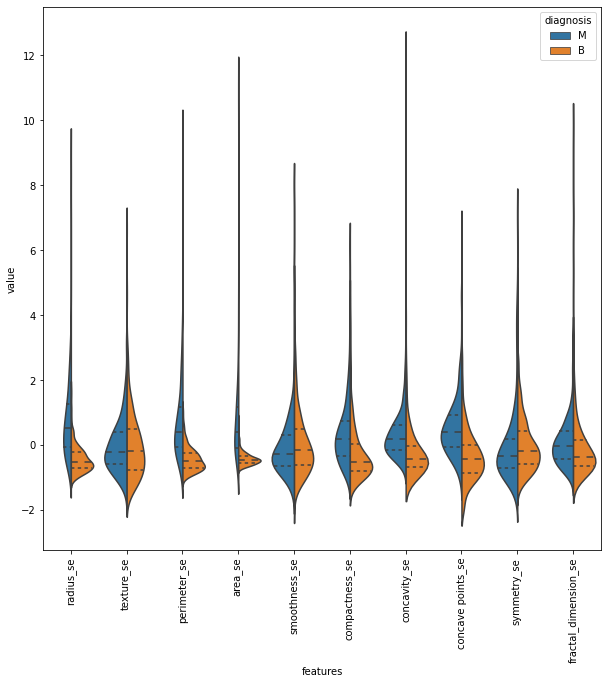

In [7]:
data = pd.concat([y,data_n_2.iloc[:,10:20]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

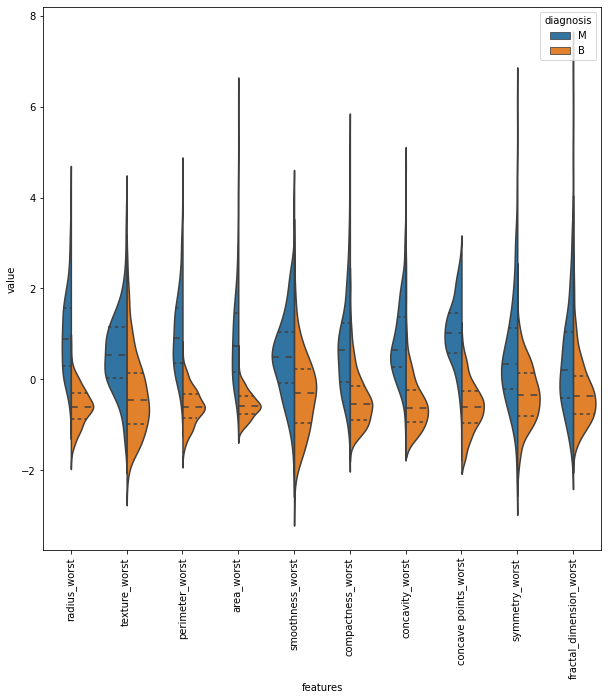

In [8]:
#worst에 관한 data visualization
data = pd.concat([y,data_n_2.iloc[:,20:31]],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

In [9]:
lb = LabelBinarizer()
df['diagnosis'] = lb.fit_transform(df['diagnosis'].values)
targets=df['diagnosis']
y=df['diagnosis']
df.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1, inplace=True)

targets

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

In [10]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.1,random_state=4)

In [11]:
clf = xgb.XGBClassifier() #!!!!!!!!  분류기 !!!!!!!!!
cv = StratifiedKFold(n_splits=10,shuffle=False)

In [12]:
clf.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [13]:
y_pred=clf.predict(x_test)

                      score
texture_worst            54
texture_mean             42
area_se                  40
area_worst               39
concave points_worst     34
smoothness_worst         33
concavity_worst          33
concave points_mean      27


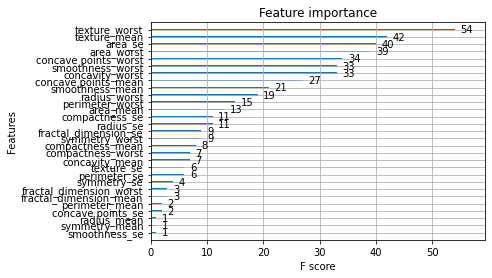

In [14]:
feature_important =clf.fit(x_train, y_train).get_booster().get_fscore()
data = pd.DataFrame(data=feature_important.values(), index=feature_important.keys(), columns=["score"]).sort_values(by = "score", ascending=False)
print(data[:8])
xgb.plot_importance(clf)

In [15]:
confusion_matrix(y_test,clf.predict(x_test))

array([[34,  2],
       [ 3, 18]])

In [16]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93        36
           1       0.90      0.86      0.88        21

    accuracy                           0.91        57
   macro avg       0.91      0.90      0.90        57
weighted avg       0.91      0.91      0.91        57



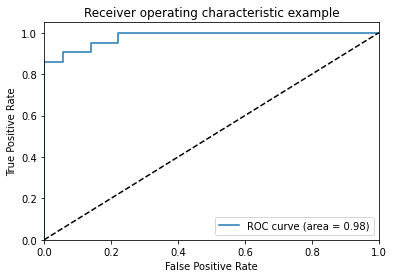

In [17]:
from sklearn.metrics import roc_curve
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(x_test)[:,1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [18]:
accuracy_score(y_test,clf.predict(x_test))

0.9122807017543859

In [19]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
cvs=cross_val_score(clf, df, targets, cv=cv)
print(cvs)
mean_acc=np.mean(cvs)
mean_acc

[1.         0.9122807  0.94736842 0.94736842 0.98245614 1.
 0.94736842 0.98245614 0.94736842 0.98214286]


0.9648809523809524

정밀도(precision)은 양성 클래스에 속한다고 출력한 샘플 중 실제로 양성 클래스에 속하는 샘플 수의 비율을 말한다.  재현율(recall)은 실제 양성 클래스에 속한 표본 중에 양성 클래스에 속한다고 출력한 표본의 수의 비율을 뜻한다. 높을수록 좋은 모형이다. F1-score은 precision과 recall의 밸런스를 측정해준다. Support는 각각의 class가 y_train에서 일어난 수이다. 

1.0
[[35  0]
 [ 0 22]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        22

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

0.9990681
실제 lable : 
1
예측 : 
1
radius_mean                  18.250000
texture_mean                 19.980000
perimeter_mean              119.600000
area_mean                  1040.000000
smoothness_mean               0.094630
compactness_mean              0.109000
concavity_mean                0.112700
concave points_mean           0.074000
symmetry_mean                 0.179400
fractal_dimension_mean        0.057420
radius_se                     0.446700
texture_se                    0.773200
perimeter_se                  3.180000
area_se                      53.910000
smoothness_se                 0.004314
compactness_se                0.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


0.9122807017543859
[[33  2]
 [ 3 19]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        35
           1       0.90      0.86      0.88        22

    accuracy                           0.91        57
   macro avg       0.91      0.90      0.91        57
weighted avg       0.91      0.91      0.91        57

0.99901104
실제 lable : 
1
예측 : 
1
radius_mean                  15.300000
texture_mean                 25.270000
perimeter_mean              102.400000
area_mean                   732.400000
smoothness_mean               0.108200
compactness_mean              0.169700
concavity_mean                0.168300
concave points_mean           0.087510
symmetry_mean                 0.192600
fractal_dimension_mean        0.065400
radius_se                     0.439000
texture_se                    1.012000
perimeter_se                  3.498000
area_se                      43.500000
smoothness_se                 0.005233
compactness_se   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


0.9473684210526315
[[35  1]
 [ 2 19]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        36
           1       0.95      0.90      0.93        21

    accuracy                           0.95        57
   macro avg       0.95      0.94      0.94        57
weighted avg       0.95      0.95      0.95        57

0.99916923
실제 lable : 
1
예측 : 
1
radius_mean                  19.210000
texture_mean                 18.570000
perimeter_mean              125.500000
area_mean                  1152.000000
smoothness_mean               0.105300
compactness_mean              0.126700
concavity_mean                0.132300
concave points_mean           0.089940
symmetry_mean                 0.191700
fractal_dimension_mean        0.059610
radius_se                     0.727500
texture_se                    1.193000
perimeter_se                  4.837000
area_se                     102.500000
smoothness_se                 0.006458
compactness_se   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


0.9473684210526315
[[36  0]
 [ 3 18]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        36
           1       1.00      0.86      0.92        21

    accuracy                           0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

0.99911314
실제 lable : 
1
예측 : 
1
radius_mean                  18.450000
texture_mean                 21.910000
perimeter_mean              120.200000
area_mean                  1075.000000
smoothness_mean               0.094300
compactness_mean              0.097090
concavity_mean                0.115300
concave points_mean           0.068470
symmetry_mean                 0.169200
fractal_dimension_mean        0.057270
radius_se                     0.595900
texture_se                    1.202000
perimeter_se                  3.766000
area_se                      68.350000
smoothness_se                 0.006001
compactness_se   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


0.9824561403508771
[[36  0]
 [ 1 20]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       1.00      0.95      0.98        21

    accuracy                           0.98        57
   macro avg       0.99      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57

0.99928397
실제 lable : 
1
예측 : 
1
radius_mean                  27.220000
texture_mean                 21.870000
perimeter_mean              182.100000
area_mean                  2250.000000
smoothness_mean               0.109400
compactness_mean              0.191400
concavity_mean                0.287100
concave points_mean           0.187800
symmetry_mean                 0.180000
fractal_dimension_mean        0.057700
radius_se                     0.836100
texture_se                    1.481000
perimeter_se                  5.820000
area_se                     128.700000
smoothness_se                 0.004631
compactness_se   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


1.0
[[36  0]
 [ 0 21]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        21

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

0.99915636
실제 lable : 
1
예측 : 
1
radius_mean                  23.210000
texture_mean                 26.970000
perimeter_mean              153.500000
area_mean                  1670.000000
smoothness_mean               0.095090
compactness_mean              0.168200
concavity_mean                0.195000
concave points_mean           0.123700
symmetry_mean                 0.190900
fractal_dimension_mean        0.063090
radius_se                     1.058000
texture_se                    0.963500
perimeter_se                  7.247000
area_se                     155.800000
smoothness_se                 0.006428
compactness_se                0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


0.9473684210526315
[[35  1]
 [ 2 19]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        36
           1       0.95      0.90      0.93        21

    accuracy                           0.95        57
   macro avg       0.95      0.94      0.94        57
weighted avg       0.95      0.95      0.95        57

0.99940467
실제 lable : 
1
예측 : 
1
radius_mean                  20.310000
texture_mean                 27.060000
perimeter_mean              132.900000
area_mean                  1288.000000
smoothness_mean               0.100000
compactness_mean              0.108800
concavity_mean                0.151900
concave points_mean           0.093330
symmetry_mean                 0.181400
fractal_dimension_mean        0.055720
radius_se                     0.397700
texture_se                    1.033000
perimeter_se                  2.587000
area_se                      52.340000
smoothness_se                 0.005043
compactness_se   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


0.9824561403508771
[[36  0]
 [ 1 20]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       1.00      0.95      0.98        21

    accuracy                           0.98        57
   macro avg       0.99      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57

0.9990633
실제 lable : 
1
예측 : 
1
radius_mean                  20.340000
texture_mean                 21.510000
perimeter_mean              135.900000
area_mean                  1264.000000
smoothness_mean               0.117000
compactness_mean              0.187500
concavity_mean                0.256500
concave points_mean           0.150400
symmetry_mean                 0.256900
fractal_dimension_mean        0.066700
radius_se                     0.570200
texture_se                    1.023000
perimeter_se                  4.012000
area_se                      69.060000
smoothness_se                 0.005485
compactness_se    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


0.9473684210526315
[[34  2]
 [ 1 20]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        36
           1       0.91      0.95      0.93        21

    accuracy                           0.95        57
   macro avg       0.94      0.95      0.94        57
weighted avg       0.95      0.95      0.95        57

0.99909806
실제 lable : 
1
예측 : 
1
radius_mean                  15.490000
texture_mean                 19.970000
perimeter_mean              102.400000
area_mean                   744.700000
smoothness_mean               0.116000
compactness_mean              0.156200
concavity_mean                0.189100
concave points_mean           0.091130
symmetry_mean                 0.192900
fractal_dimension_mean        0.067440
radius_se                     0.647000
texture_se                    1.331000
perimeter_se                  4.675000
area_se                      66.910000
smoothness_se                 0.007269
compactness_se   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


0.9821428571428571
[[35  0]
 [ 1 20]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       1.00      0.95      0.98        21

    accuracy                           0.98        56
   macro avg       0.99      0.98      0.98        56
weighted avg       0.98      0.98      0.98        56

0.9990306
실제 lable : 
1
예측 : 
1
radius_mean                  20.590000
texture_mean                 21.240000
perimeter_mean              137.800000
area_mean                  1320.000000
smoothness_mean               0.108500
compactness_mean              0.164400
concavity_mean                0.218800
concave points_mean           0.112100
symmetry_mean                 0.184800
fractal_dimension_mean        0.062220
radius_se                     0.590400
texture_se                    1.216000
perimeter_se                  4.206000
area_se                      75.090000
smoothness_se                 0.006666
compactness_se    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


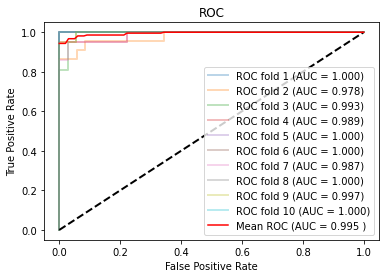

In [20]:
tprs = []
aucs = []

mean_fpr = np.linspace(0,1,100) # 기본적으로 배열을 0에서 1사이의 값을 100등분한 것으로 채워라!
i = 1
for train,test in cv.split(df,targets):
    prob=clf.fit(df.iloc[train], targets.iloc[train]).predict_proba(df.iloc[test])[:,1] #실제 positive에 대한 prob를 구해서 prob으로 넣어줘야함...ㅠㅠ
    y_pred=clf.predict(df.iloc[test]) # k-fold를 진행할 때 마다의 y_test에 대한 prediction
    c_mat=confusion_matrix(targets[test],y_pred)
    print(accuracy_score(targets[test],y_pred))
    print(c_mat)
    print(classification_report(targets[test],y_pred))
    for k in range(len(targets[test])):
      if targets[test].iloc[k]==y_pred[k]: 
        #여기서 ==라고 하면 예측과 실제가 맞는 것의 확률, 특성이 나오고 =!로 하면 예측과 실제가 맞지 않는 것의 확률, 특성이 나옴
          if y_pred[k] == 1 and prob[k]>0.999: #확률에 따라 출력하고 싶은 값들을 조절할 수 있다.
           print(prob[k])
           print("실제 lable : ")
           print(targets[test].iloc[k])
           print("예측 : ")
           print(y_pred[k])         
           print(df.iloc[test].iloc[k,:])
      elif y_pred[k]==0 and 1-prob[k]>0.999:
         print(1-prob[k])
         print("실제 lable : ")
         print(targets[test].iloc[k])
         print("예측 : ")
         print(y_pred[k]) 
         print(df.iloc[test].iloc[k,:])
    fpr, tpr, t = roc_curve(targets[test],prob)
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    feature_important =clf.fit(df.iloc[train], targets.iloc[train]).get_booster().get_fscore()
    data = pd.DataFrame(data=feature_important.values(), index=feature_important.keys(), columns=["score"]).sort_values(by = "score", ascending=False)
    print(data[:8])


    plt.plot(fpr, tpr,lw=2, alpha=0.3, label=r'ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
    plt.legend(loc="lower right")
    i= i+1


plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='red',
         label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()
